## Installing required libraries

In [ ]:
!pip3 install numpy
!pip3 install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162514 sha256=ec403d4df1c3d8dd0ad1db82c63aa133238790e55ae3567d9924818097dd1afe
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## Importing required libraries

In [ ]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd

## Importing data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/vaishsinghds/Movies-recommendation-engine/main/ratings_small.csv")

In [21]:
df

,userID,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [ ]:
df['rating'].unique()

array([2.5, 3. , 2. , 4. , 3.5, 1. , 5. , 4.5, 1.5, 0.5])

<ipython-input-7-d89a0a566a5d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


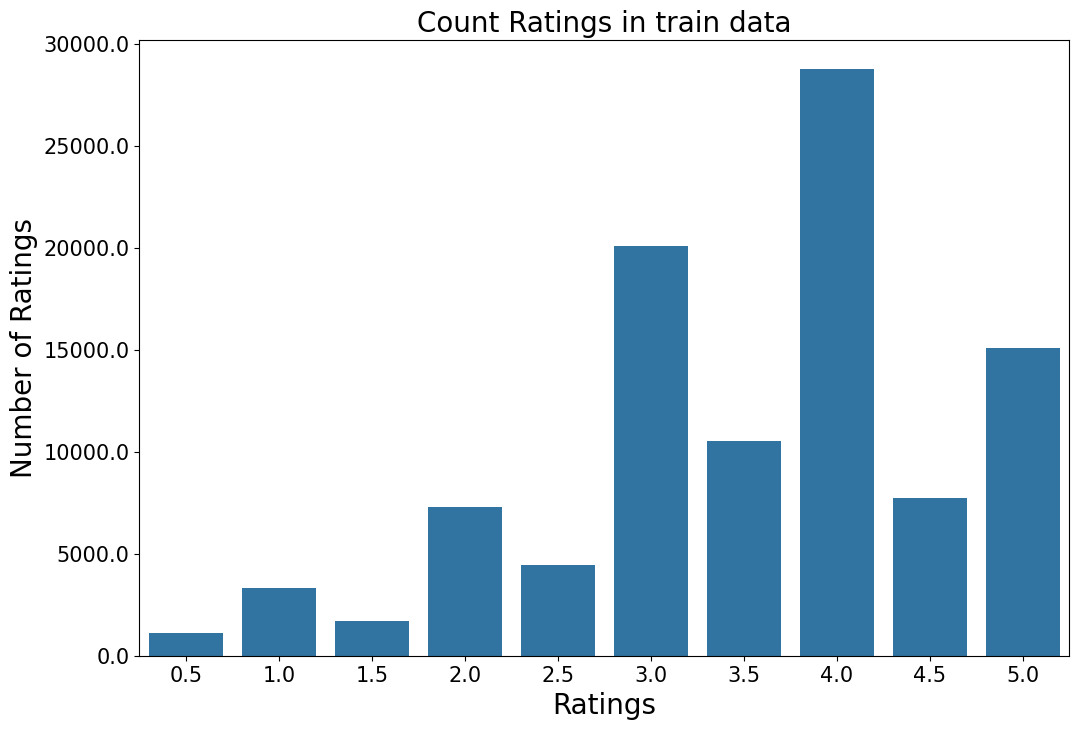

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [ ]:
df.tail()

,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


In [ ]:
df.drop(['timestamp'], axis=1, inplace=True)
df.columns = ['userID', 'movieId', 'rating']

In [ ]:
df.head()

,userID,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [15]:
df.shape

(100004, 3)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userID   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [17]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::20000, :])

Dataset shape: (100004, 3)
-Dataset examples-
        userID  movieId  rating
0            1       31     2.5
20000      133    72395     0.5
40000      292     4034     3.0
60000      433     8641     4.5
80000      547     8507     4.0
100000     671     6269     4.0


## EDA

### Ratings Distribution

<ipython-input-18-d89a0a566a5d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


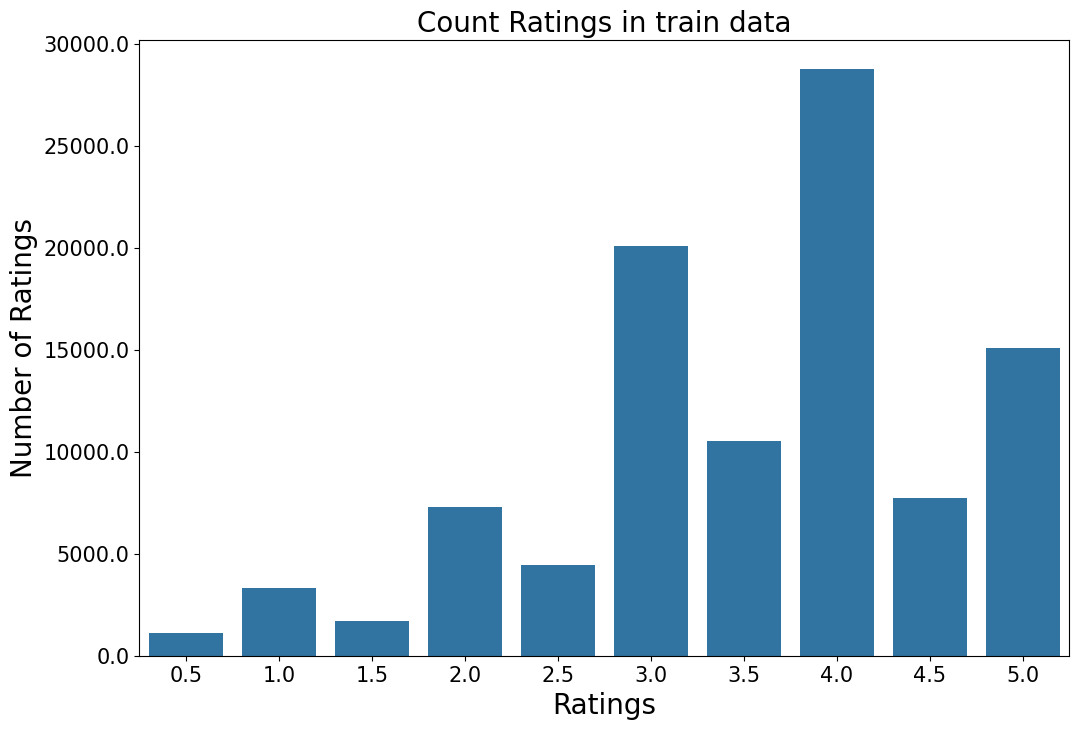

In [18]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

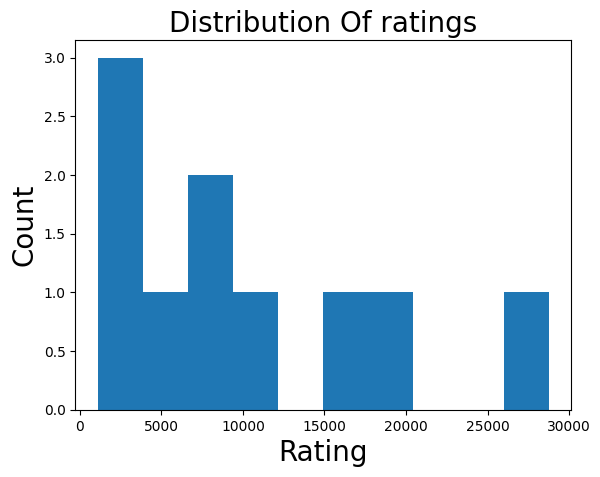

In [23]:
# Rating Distribution
data = df['rating'].value_counts().sort_index(ascending=False)
plt.hist(data)
plt.title("Distribution Of ratings", fontsize = 20)
plt.xlabel("Rating", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.show()

### Ratings Distribution By Item

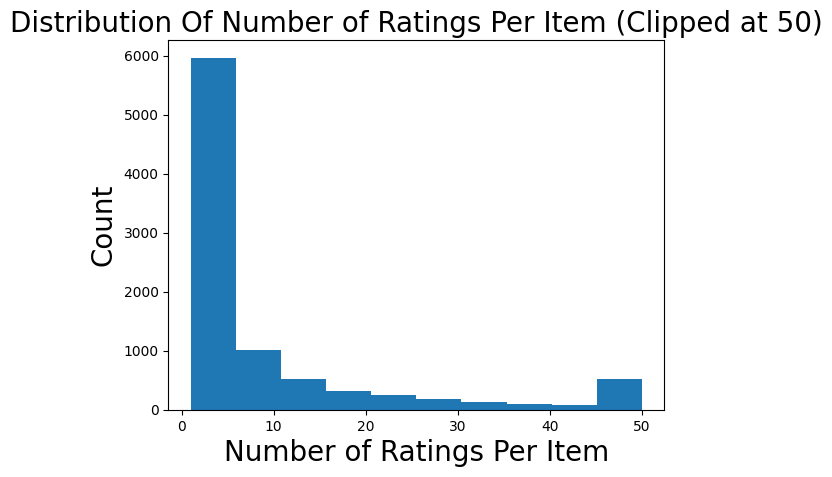

In [20]:
# Number of ratings per movie
data = df.groupby('movieId')['rating'].count().clip(upper=50)
plt.hist(data)
plt.title("Distribution Of Number of Ratings Per Item (Clipped at 50)", fontsize = 20)
plt.xlabel("Number of Ratings Per Item", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.show()

### Ratings Distribution By User

In [ ]:
df.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,movieId,rating
321,356,341
266,296,324
284,318,311
525,593,304
232,260,291
427,480,274
2062,2571,259
0,1,247
472,527,244
522,589,237


In [ ]:
df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userID,rating
546,547,2391
563,564,1868
623,624,1735
14,15,1700
72,73,1610
451,452,1340
467,468,1291
379,380,1063
310,311,1019
29,30,1011


### Dimensionality

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users

In [ ]:
min_ratings = 5
filter_items = df['movieId'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 5
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['movieId'].isin(filter_items)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(100004, 3)
The new data frame shape:	(88087, 3)


## Surprise

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new[['userID', 'movieId', 'rating']], reader)

### Basic algorithms

With the Surprise library, we will benchmark the following algorithms



#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

* KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

#### KNNWithZScore

* KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### SVDpp

* The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

### Co-clustering

* Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)


We use rmse as our accuracy metric for the predictions.

In [ ]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7b05861843d0>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7b0586307c40>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7b05863048e0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7b05863079a0>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7b05863067d0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7b05863077c0>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x7b0586304a30>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7b0586307130>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7b058b7d1c00>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7b058b7d3a00>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7b058b7d0f10>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7b05861

<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7b05861843d0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7b0586307c40>


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7b0586307c40> 


Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7b05863048e0>


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7b05863048e0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7b05863079a0>


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7b05863079a0> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7b05863067d0>


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7b05863067d0> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7b05863077c0>
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7b05863077c0> 


Starting:  <surprise.prediction_algorithms.knns.KNNBasic object at 0x7b0586304a30>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNBasic object at 0x7b0586304a30> 


Starting:  <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7b0586307130>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7b0586307130> 


Starting:  <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7b058b7d1c00>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7b058b7d1c00> 


Starting:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7b058b7d3a00>
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7b058b7d3a00> 


Starting:  <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7b058b7d0f10>
Done:  <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7b058b7d0f10> 



	DONE



<ipython-input-54-1c3e2d6ceed8>:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.872706,38.488395,12.409603
KNNBaseline,0.877017,0.451539,3.120500
BaselineOnly,0.881773,0.282895,0.214363
SVD,0.884817,1.542592,0.398531
KNNWithZScore,0.889795,0.238960,2.843532
KNNWithMeans,0.890326,0.169881,2.453717
SlopeOne,0.898549,1.636756,6.923561
NMF,0.925014,2.104247,0.281864
CoClustering,0.941083,1.928307,0.193151


SVDpp is performing best but it is taking a lot of time so we will use SED instean but apply GridSearch CV.

In [ ]:
# param_grid = {
#     "n_epochs": [5, 10, 15, 20, 30, 40, 50, 100],
#     "lr_all": [0.001, 0.002, 0.005],
#     "reg_all": [0.02, 0.08, 0.4, 0.6]
# }

# smaller grid for testing
param_grid = {
    "n_epochs": [10, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.8797082491912865
BEST MAE: 	 0.6766435510682525
BEST params: 	 {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


In [ ]:
from datetime import datetime
print(training_parameters)
reader = Reader(rating_scale=(1, 5))

print("\n\n\t\t STARTING\n\n")
start = datetime.now()

print("> Loading data...")
data = Dataset.load_from_df(df_new[['userID', 'movieId', 'rating']], reader)
print("> OK")

print("> Creating trainset...")
trainset = data.build_full_trainset()
print("> OK")


startTraining = datetime.now()
print("> Training...")

algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

algo.fit(trainset)

endTraining = datetime.now()
print("> OK \t\t It Took: ", (endTraining-startTraining).seconds, "seconds")

end = datetime.now()
print (">> DONE \t\t It Took", (end-start).seconds, "seconds" )

{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


		 STARTING


> Loading data...
> OK
> Creating trainset...
> OK
> Training...
> OK 		 It Took:  1 seconds
>> DONE 		 It Took 1 seconds


In [ ]:
## SAVING TRAINED MODEL
from surprise import dump
import os
model_filename = "./model.pickle"
print (">> Starting dump")
# Dump algorithm and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=algo)
print (">> Dump done")
print(model_filename)

>> Starting dump
>> Dump done
/content/sample_data/model.pickle


In [ ]:
## LOAD SAVED MODEL
def load_model(model_filename):
    print (">> Loading dump")
    from surprise import dump
    import os
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    print (">> Loaded dump")
    return loaded_model

In [ ]:
# predicitng
from pprint import pprint as pp
model_filename = "./model.pickle"
def itemRating(user, item):
    uid = str(user)
    iid = str(item)
    loaded_model = load_model(model_filename)
    prediction = loaded_model.predict(user, item, verbose=True)
    rating = prediction.est
    details = prediction.details
    uid = prediction.uid
    iid = prediction.iid
    true = prediction.r_ui
    ret = {
        'user': user,
        'item': item,
        'rating': rating,
        'details': details,
        'uid': uid,
        'iid': iid,
        'true': true
        }
    pp (ret)
    print ('\n\n')
    return ret
print(itemRating(user = "610", item = "10"))

>> Loading dump
>> Loaded dump
user: 610        item: 10         r_ui = None   est = 3.58   {'was_impossible': False}
{'details': {'was_impossible': False},
 'iid': '10',
 'item': '10',
 'rating': 3.5843086948130827,
 'true': None,
 'uid': '610',
 'user': '610'}



{'user': '610', 'item': '10', 'rating': 3.5843086948130827, 'details': {'was_impossible': False}, 'uid': '610', 'iid': '10', 'true': None}
